# Goal

Datasets:
1. CIFAR-10
2. MNIST

Models:
1. Convolutional Features
2. ReLU Features
3. Fourier Features

Each model transforms the data to a feature matrix $[M_{TM} | M_{TU}]$ where $M_{TM}$ is the data matrix for the training set and $M_{TU}$ are the basis functions that we have not yet modeled. We will compute the best coefficients, $\tilde{c}$ of basis functions to model the labels on the modeled training set and the best coefficients, $c$, of all basis functions to model the labels on the whole training set. We will then compute the error $c_{err} = \tilde{c}-c^*$ where $c^*$ is the truncated version of $c$ to match the size of $\tilde{c}$. We initialize $c$ with the least-squares coefficients learned from the whole training set. Then we compute $\tilde{c}$ by solving the least-squares problem on the sampled training set. 

For each dataset, we will:
- Sample the features uniformly at random vs by leverage scores.
- Plot $||A||_2$, $||M_{TM}^+||_2$, and $||\tilde{c}-c^*||_2$ for the sampled features as a function of the number of sampled points.

We expect to see that leverage score sampling leads to a smaller error $||\tilde{c}-c^*||_2$ for the same number of sampled points.


## MNIST

The MNIST dataset consists of 70,000 images of handwritten digits (0-9) in grayscale with a resolution of 28x28 pixels. This gives us a $70,000 \times 784$ data matrix.
- A Convolutional Neural network will transform the data to a $70,000 \times 200$ matrix (by removing the last layer).
- A Random ReLU fully-connected network ($y({\textbf{t}}) = \sum_{k=1}^{200} w_k \sigma(\left<\textbf{t}, {\textbf{v}}_k\right>)$ with $\sigma(x) = \max(0,x)$ and $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.
- A Fourier fully-connected network ($y({\textbf{t}}) = \mathscr{R}(\sum_{k=1}^{200} w_k \exp(i\pi\left<\textbf{t}, {\textbf{v}}_k\right>)) = \sum_{k=1}^{200} w_k \cos(\pi\left<\textbf{t}, {\textbf{v}}_k\right>) = $ with $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.

In [2]:
import numpy as np
import torch
import graphlearning as gl

mnist_digits, mnist_labels = gl.datasets.load("mnist")

mnist_X = torch.tensor(mnist_digits, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0
mnist_y = torch.tensor(mnist_labels, dtype=torch.long)


In [ ]:
# Random Fourier Features
def rff_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)

    W = torch.randn(X.shape[1], features)

    return torch.cos(torch.pi * X @ W) / np.sqrt(features)  # Normalize

mnist_rff_features = rff_features(mnist_X, features=2000)

# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features)
    return torch.relu(X @ W)  / np.sqrt(features)

mnist_relu_features = relu_features(mnist_X, features=2000)


In [4]:
# Verify CNN accuracy on MNIST

from models.mnist_cnn import ConvNet, BASIS_FUNCTIONS
from torch.utils.data import TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network = ConvNet()
network.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=device))
network.eval()

def verify_mnist_cnn(model: ConvNet, device):
    model.to(device)
    indices = torch.randperm(mnist_X.shape[0])
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(
        TensorDataset(mnist_X[indices], mnist_y[indices]),
    )
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds: torch.Tensor = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    print(f"Test accuracy: {correct / total:.4f}")
verify_mnist_cnn(network, device)

Test accuracy: 0.9846


We get an accuracy on the whole dataset of `0.9846`. Pretty good. Now we can embed the data using the convolutional layers of the network and use that as our feature matrix for sampling.

In [ ]:
# Embed the data using the convolutional layers of the network
mnist_cnn_embedding = torch.tensor(np.zeros((mnist_X.shape[0], BASIS_FUNCTIONS)))

with torch.no_grad():
    for batch_start in range(0, mnist_X.shape[0], 256):
        batch_end = min(batch_start + 256, mnist_X.shape[0])
        batch = mnist_X[batch_start:batch_end].to(device)
        embeddings = network.embed(batch)
        mnist_cnn_embedding[batch_start:batch_end] = embeddings

mnist_cnn_embedding.shape

torch.Size([70000, 200])

In [14]:
import numpy as np
from matplotlib import pyplot as plt


def simulation(
    M: torch.Tensor,
    embedding_label: str,
    modeled_basis_functions: int = 100,
    sample_points: int = 5000,
    sample_point_step: int = 100,
    trials: int = 10,
    ):
    print("Running simulation for", embedding_label)
    device = M.device
    MNIST_ONE_HOT_LABELS_TORCH = torch.nn.functional.one_hot(mnist_y, num_classes=10).to(device, dtype=torch.float32)
    MNIST_ONE_HOT_LABELS_NORM_TORCH = MNIST_ONE_HOT_LABELS_TORCH.norm()

    c_true = torch.linalg.lstsq(M, MNIST_ONE_HOT_LABELS_TORCH).solution
    M_TM = M[:, :modeled_basis_functions]

    x_axis = range(sample_point_step, sample_points, sample_point_step)
    
    errors_random_avg = []
    errors_top_leverage_avg = []
    errors_random_leverage_avg = []

    parameter_errors_random_avg = []
    parameter_errors_leverage_avg = []
    parameter_errors_random_leverage_avg = []

    for n in x_axis:
        errors_random = []
        errors_leverage = []
        errors_random_leverage = []

        parameter_errors_random = []
        parameter_errors_leverage = []
        parameter_errors_random_leverage = []

        print(f"Sampling {n} points...")
        for _ in range(trials):
            random_indices = torch.randperm(M.shape[0], device=device)[:n]
            leverage_scores = torch.linalg.norm(torch.linalg.qr(M_TM, mode='reduced').Q, dim=1) ** 2
            top_leverage_indices = torch.topk(leverage_scores, n, largest=True).indices

            # Evaluate Random Sampling
            M_TM_random = M_TM[random_indices, :]
            c_random = torch.linalg.lstsq(M_TM_random, MNIST_ONE_HOT_LABELS_TORCH[random_indices, :]).solution
            y_random = M_TM @ c_random
            error_random = torch.linalg.norm(MNIST_ONE_HOT_LABELS_TORCH - y_random, ord="fro") / MNIST_ONE_HOT_LABELS_NORM_TORCH
            parameter_error_random = (c_true[:modeled_basis_functions] - c_random).norm() / c_true[:modeled_basis_functions].norm()

            # Evaluate Top Leverage Score Sampling
            M_TM_leverage = M_TM[top_leverage_indices, :]
            c_leverage = torch.linalg.lstsq(M_TM_leverage, MNIST_ONE_HOT_LABELS_TORCH[top_leverage_indices, :]).solution
            y_leverage = M_TM @ c_leverage
            error_leverage = torch.linalg.norm(MNIST_ONE_HOT_LABELS_TORCH - y_leverage, ord="fro") / MNIST_ONE_HOT_LABELS_NORM_TORCH
            parameter_error_leverage = (c_true[:modeled_basis_functions] - c_leverage).norm() / c_true[:modeled_basis_functions].norm()

            # Evaluate Random leverage score sampling with replacement
            random_leverage_indices = torch.multinomial(leverage_scores, n, replacement=True)
            M_TM_random_leverage = M_TM[random_leverage_indices, :]
            c_random_leverage = torch.linalg.lstsq(M_TM_random_leverage, MNIST_ONE_HOT_LABELS_TORCH[random_leverage_indices, :]).solution
            y_random_leverage = M_TM @ c_random_leverage
            error_random_leverage = torch.linalg.norm(MNIST_ONE_HOT_LABELS_TORCH - y_random_leverage, ord="fro") / MNIST_ONE_HOT_LABELS_NORM_TORCH
            parameter_error_random_leverage = (c_true[:modeled_basis_functions] - c_random_leverage).norm() / c_true[:modeled_basis_functions].norm()

            errors_random.append(error_random.item())
            errors_leverage.append(error_leverage.item())
            errors_random_leverage.append(error_random_leverage.item())

            parameter_errors_random.append(parameter_error_random.item())
            parameter_errors_leverage.append(parameter_error_leverage.item())
            parameter_errors_random_leverage.append(parameter_error_random_leverage.item())
        
        errors_random_avg.append(torch.tensor(errors_random).mean().item())
        errors_top_leverage_avg.append(torch.tensor(errors_leverage).mean().item())
        errors_random_leverage_avg.append(torch.tensor(errors_random_leverage).mean().item())
        parameter_errors_random_avg.append(torch.tensor(parameter_errors_random).mean().item())
        parameter_errors_leverage_avg.append(torch.tensor(parameter_errors_leverage).mean().item())
        parameter_errors_random_leverage_avg.append(torch.tensor(parameter_errors_random_leverage).mean().item())

    return (x_axis, errors_random_avg, errors_top_leverage_avg, errors_random_leverage_avg, parameter_errors_random_avg, parameter_errors_leverage_avg, parameter_errors_random_leverage_avg, embedding_label)

In [15]:
data1 = simulation(mnist_cnn_embedding.float(), "CNN", modeled_basis_functions=100, sample_points=5000, trials=10)
data2 = simulation(mnist_rff_features.float(), "RFF", modeled_basis_functions=100, sample_points=5000, trials=10)
data3 = simulation(mnist_relu_features.float(), "ReLU", modeled_basis_functions=100, sample_points=5000, trials=10)

Running simulation for CNN
Sampling 100 points...
Sampling 200 points...
Sampling 300 points...
Sampling 400 points...
Sampling 500 points...
Sampling 600 points...
Sampling 700 points...
Sampling 800 points...


KeyboardInterrupt: 

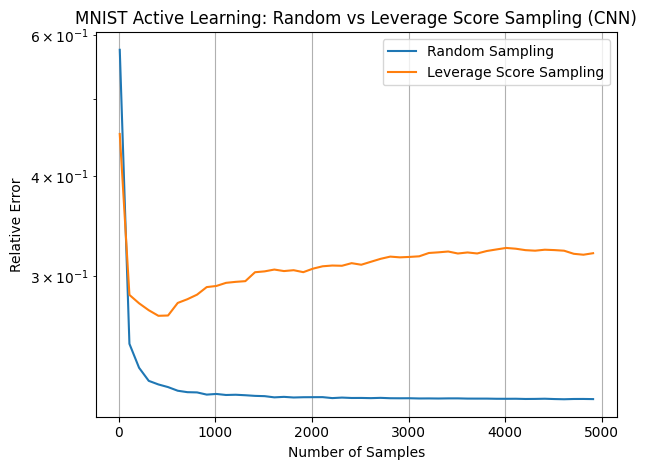

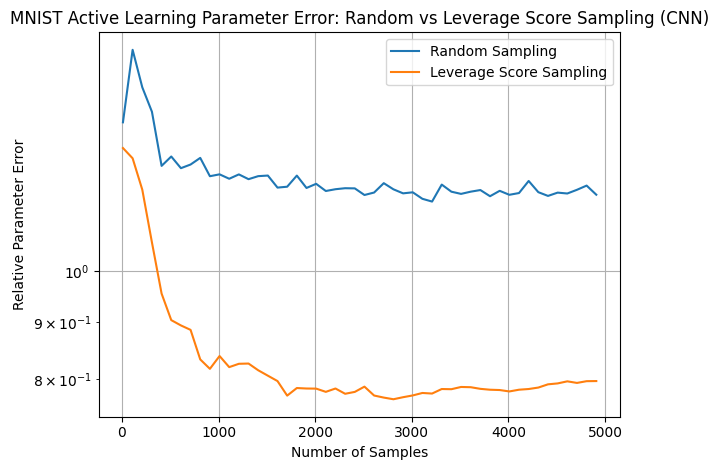

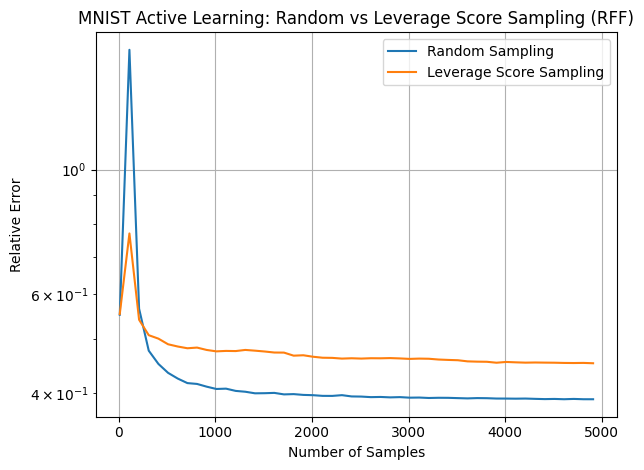

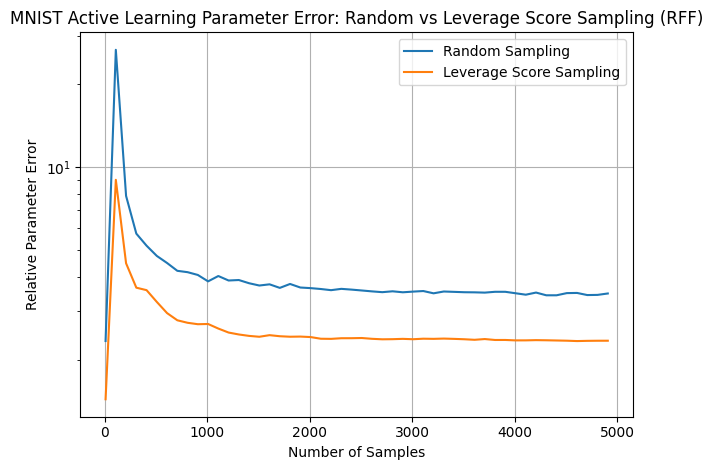

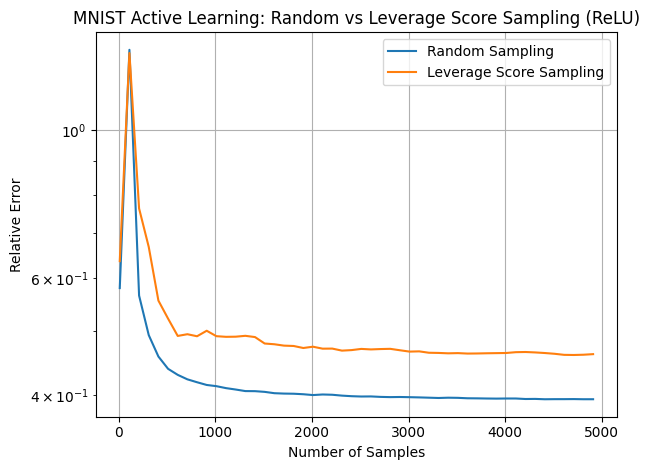

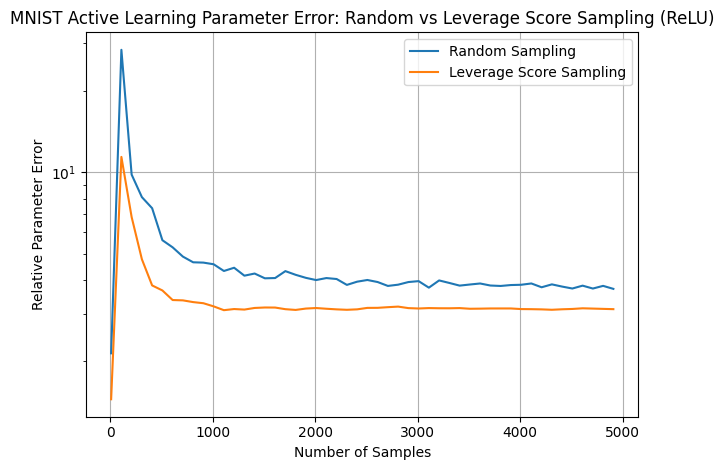

In [ ]:
def plot_data(
        x_axis,
        errors_random_avg,
        errors_leverage_avg,
        parameter_errors_random_avg,
        parameter_errors_leverage_avg,
        embedding_label: str,
    ):
    plt.semilogy(x_axis, errors_random_avg, label='Random Sampling')
    plt.semilogy(x_axis, errors_leverage_avg, label='Leverage Score Sampling')
    plt.xlabel('Number of Samples')
    plt.ylabel('Relative Error')
    plt.title(f'MNIST Active Learning: Random vs Leverage Score Sampling ({embedding_label})')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.semilogy(x_axis, parameter_errors_random_avg, label='Random Sampling')
    plt.semilogy(x_axis, parameter_errors_leverage_avg, label='Leverage Score Sampling')
    plt.xlabel('Number of Samples')
    plt.ylabel('Relative Parameter Error')
    plt.title(f'MNIST Active Learning Parameter Error: Random vs Leverage Score Sampling ({embedding_label})')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


plot_data(*data1)
plot_data(*data2)
plot_data(*data3)

## CIFAR-10

The CIFAR-10 dataset consists of 60,000 images in color with a resolution of 32x32 pixels, divided into 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). This gives us a 60,000 x 32 x 32 x 3 = 60,000 x 3072 data matrix.

In [ ]:
cifar, cifar_labels = gl.datasets.load("cifar10")

cifar_X = torch.tensor(cifar, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
cifar_y = torch.tensor(cifar_labels, dtype=torch.long)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 4